# Code for The Random Puzzlers

You can find a complete write up on ericniblock.com. I fully acknowledge that this is not the most efficient solution to this problem, though it is elegant in a sense.

In [ ]:
import networkx 
from networkx.algorithms.components.connected import connected_components
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [23]:
def create_game(M, N, players):
    ## Input: Columns, Rows, Number of Players
    ## Output: A matrix of size N x M which assigns a player to each piece of the puzzle
    
    ## Note: Make M divisible by the number of players, just for simplicity
    
    owner = np.ones((M,N))
    scope = M/players
    playlist = list(range(players))
    for p in range(len(playlist)):
        owner[int(playlist[p]*scope):int((playlist[p]+1)*scope),:] = playlist[p]
    owner = owner.ravel()
    np.random.shuffle(owner)
    owner = owner.reshape(M,N)
    return(owner)

In [24]:
def possible_pieces(M,N):
    ## Input: Columns, Rows
    ## Output: A dictionary with an index for each piece, and who's entries describe valid connections 
    
    relevant = {}
    for y in range(M):
        for x in range(N):
            relevant[(y,x)] = []
            if y != 0:
                relevant[(y,x)].append((y-1,x))
            if y != M-1:
                relevant[(y,x)].append((y+1,x))
            if x != 0:
                relevant[(y,x)].append((y,x-1))
            if x != N-1:
                relevant[(y,x)].append((y,x+1))
    return(relevant)

In [22]:
def to_graph(l):
    ## Input: A list of sublists, where a sublist exists for every singular piece and contains all valid 
    ##        connections for just that singular piece
    ## Output: A network of these 'nodes'
    
    G = networkx.Graph()
    for part in l:
        G.add_nodes_from(part)
        G.add_edges_from(to_edges(part))
    return G

def to_edges(l):
    ## Input: The network created above
    ## Output: A network with newly formed edges connecting sublists that share common elements

    it = iter(l)
    last = next(it)
    for current in it:
        yield last, current
        last = current    

In [25]:
def run_round(relevant, owner):
    ## Input: A dictionary describing valid connections (generated from 'possible_pieces'), 
    ##        and a matrix of size N x M which assigns a player to each piece of the puzzle
    ## Output: A list of sublists, with each sublist containing a 'piece' (all contiguous 
    ##        sets of pieces, and remaining single pieces)
    
    all_matches = []
    for key in list(relevant.keys()):
        num = owner[key[0],key[1]]
        match = [key]
        for option in relevant[key]:
            if owner[option[0],option[1]] == num:
                match.append(option)
        all_matches.append(match)
    G = to_graph(all_matches)
    groups = list(connected_components(G))
    groups = [list(i) for i in groups]
    return(groups)

In [26]:
def new_owners(owners, groups, players):
    ## Input: A matrix of size N x M which assigns a player to each piece of the puzzle, 
    ##        group-lists generated from 'run_round', and the number of players
    ## Output: A new matrix of size N x M which assigns a player to each piece of the 
    ##        puzzle from the set of congealed pieces
    
    owner = owners
    num, div = len(groups), players
    split = [num // div + (1 if x < num % div else 0)  for x in range (div)]
    newsplit = split
    for i in range(1,len(split)):
        newsplit[i] = split[i]+split[i-1]
    newsplit = [0] + newsplit
    new = np.zeros(len(groups))
    for e in range(len(newsplit)-1):
        new[newsplit[e]:newsplit[e+1]] = e
    np.random.shuffle(new)
    for k in range(len(groups)):
        temp = groups[k]
        for l in temp:
            owner[l[0],l[1]] = new[k]
    return(owner)

In [27]:
## This runs a simulation of solving the puzzle for a given number of rounds, and stores the puzzle after each round

M = 20                 ## Columns
N = 50                 ## Rows
players = 5            ## M must be divisible by players
num_rounds = 10        ## How many rounds to simulate

start = create_game(M,N,players)
r = possible_pieces(M,N)

ownership = start
data_matrix = [start.copy()]

for t in range(num_rounds):
    groups = run_round(r, ownership)
    ownership = new_owners(ownership, groups, players)
    data_matrix.append(ownership.copy())

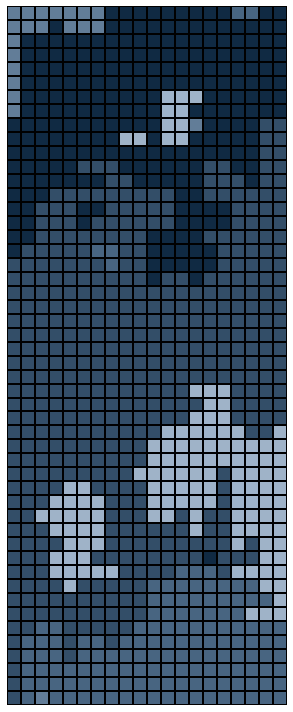

In [41]:
## Use this to plot any round from the simulation ran above

fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(10,10))
# make color map
my_cmap = matplotlib.colors.ListedColormap(['#9FB3C8' ,
'#627D98' ,
'#486581' ,
'#334E68' ,
'#102A43'])
# set the 'bad' values (nan) to be white and transparent
my_cmap.set_bad(color='w', alpha=0)
# draw the grid
for x in range(N + 1):
    ax.axhline(x, lw=2, color='k', zorder=5)
for x in range(M + 1):
    ax.axvline(x, lw=2, color='k', zorder=5)
# draw the boxes

ax.imshow(data_matrix[9].T, interpolation='none', cmap=my_cmap, extent=[0, M, 0, N], zorder=0) ## Pick round here (change index)
# turn off the axis labels
ax.axis('off')
plt.savefig('test_picpz9.png')

Everything below this point just contains the the code used to construct the plots on ericniblock.com. There is no explanation or annotation.

In [101]:
sliding = []
thresh = [20,30,40,50,60,70,80,90,100,120,140,160,180,200]
for m in thresh:
    totrss = []
    for ii in range(1000):
        rss = []
        M = m ## Columns
        N = 50 ## Rows
        players = 5

        start = create_game(M,N,players)
        r = possible_pieces(M,N)

        ownership = start

        for t in range(10):
            groups = run_round(r, ownership)
            sizesing = 0
            for g in groups:
                if len(g) == 1:
                    sizesing+=1
            rss.append(sizesing)
            ownership = new_owners(ownership, groups, players)
    
        totrss.append(rss)
    sliding.append(np.array(totrss))

In [118]:
thresh = [20,30,40,50,60,70,80,90,100,120,140,160,180,200]
all_xs = []
all_vals = []
all_errs = []
for m in range(len(thresh)):
    xs = []
    vals = []
    errs = []
    for col in range(10):
        xs.append(col+1)
        vals.append(np.mean(sliding[m][:,col]/(50*thresh[m]))) 
        errs.append(np.std(sliding[m][:,col]/(50*thresh[m]))/(1000**0.5))
    all_xs.append(xs)
    all_vals.append(vals)
    all_errs.append(errs)

In [226]:
import plotly.offline as pyo
import plotly.graph_objs as go
pyo.offline.init_notebook_mode(connected=True)

data = []

for s in range(len(sliding)):
    
    trace = go.Scatter(
        x = all_xs[s],
        y = all_vals[s],
        showlegend=True,
#         error_y=dict(
#             type='data',
#             symmetric=False,
#             array=np.array(all_errs[s])*1.96,
#             arrayminus=np.array(all_errs[s])*1.96),
        mode = 'markers',
        name=str(thresh[s]),
        line = dict(
            color = matplotlib.colors.rgb2hex(cm(s)),
            width = 2),
    )
    
    data.append(trace)

layout = go.Layout(
    title = 'Proportion of Single Pieces Remaining as a Function of the Number of Rounds',
    width=8*88,
    height=6*88,
#     margin=go.layout.Margin(
#         l=50,
#         r=80,
#         b=80,
#         t=100),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=1.1),
        showlegend=True,
    xaxis=dict(
        title = 'Number of Rounds Played',
        showline=False,
        zeroline=False
    ),
    yaxis=dict(
        title = 'Proportion of Single Pieces',
        zeroline=False
    ),
    annotations=[
        dict(
            x=1.07,
            y=1.04,
            align="right",
            valign="top",
            text='Puzzle Width',
            showarrow=False,
            xref="paper",
            yref="paper",
            xanchor="center",
            yanchor="top"
        )
    ]
)

fig = go.Figure(data=data, layout=layout)
fig.write_html("puzzlewidth.html")
pyo.iplot(fig, filename='line-mode')

In [227]:
l=50
ratio = []
for w in thresh:
    ratio.append(((l-1)*(w-1))/(l+l+w+w-4))

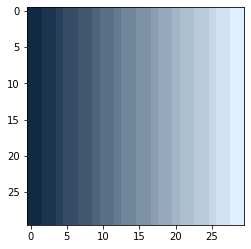

In [130]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

colors = ['#102A43', '#deefff'] # first color is black, last is red
cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=18)
mat = np.indices((30,30))[1]
plt.imshow(mat, cmap=cm)
plt.show()

In [116]:
matplotlib.colors.rgb2hex(cm(11))

'#cddfef'

In [190]:
V = np.array(all_vals)
E = np.array(all_errs)

In [236]:
import plotly.offline as pyo
import plotly.graph_objs as go
pyo.offline.init_notebook_mode(connected=True)

data = []
colors = [0,2,4,6,7,8,10,12,14,15]

for v in range(len(V[0,:])):  
    trace = go.Scatter(
        x = thresh,
        y = V[:,v],
        showlegend=True,
        error_y=dict(
            type='data',
            symmetric=True,
            array=np.array(E[:,v])*2.581),
        mode = 'markers',
        name = str(v+1),
        line = dict(
            color = matplotlib.colors.rgb2hex(cm(colors[v])),
            width = 2))
    data.append(trace)
trace = go.Scatter(
    x = thresh,
    y = 1/np.array(ratio),
    showlegend=True,
#     error_y=dict(
#         type='data',
#         symmetric=False,
#         array=np.array(E[:,v])*2.581,
#         arrayminus=np.array(E[:,v])*2.581),
    mode = 'markers',
    name = 'P/A',
    line = dict(
        color = 'gold',
        width = 2))
data.append(trace)
layout = go.Layout(
    title = 'Proportion of Single Pieces Remaining As a Function of Puzzle Width',
    showlegend=True,
    width=8*88,
    height=6*88,
    xaxis=dict(
        title = 'Puzzle Width',
        showline=False,
        zeroline=False
    ),
    yaxis=dict(
        title = 'Proportion of Single Pieces',
        zeroline=False
    ),
    annotations=[
        dict(
            x=1.07,
            y=1.04,
            align="right",
            valign="top",
            text='Round',
            showarrow=False,
            xref="paper",
            yref="paper",
            xanchor="center",
            yanchor="top"
        )
    ]
)

fig = go.Figure(data, layout=layout)
fig.write_html("puzzleround.html")
pyo.iplot(fig, filename='line-mode')